# Smart City Hackathon - Main Notebook

This jupyter noteboook provides the main components to work with SWMM, adapt models for exploration and apply a sensitivity analysis with SALib. The notebook has three main parts:
1. The setup of a model with adapted parameters of LID controls
2. The setup of a model with the application of LID controls to subcatchments
3. The execution of a model via a SWMM simulation
4. The analysis of the obtained results and a comparison to the baseline model
5. The general structure of a sensitivity analysis with SALib

### But first, the imports:

In [ ]:
import swmmio
import os
import sys
import pandas as pd
import pprint
sys.path.append("../")

import src.utils.auxiliary_functions as aux
import src.utils.run_model as rm
import src.utils.lid_manipulation_utils as lm
from paths import *
from src.utils.lid_data import lidNames, lidParams, lidLayers, lidParamsPerLayer, lidLayersPerControl, lidParamStdValues

## 1. Setup of a new model with adapted parameters of LID controls
First, you need to set the new folder and file names, under which you want to save the modified model. If you do not change this, your previuosly modified model will be overwritten.

In [ ]:
# Adapt these two parameters to save model adaptations to new directories and under meaningful names
new_directory_name_lidparams = 'test'
new_filename_lidparams = 'test'

new_directory_path_lidparams = os.path.join(DATA_DIR, new_directory_name_lidparams)

Next, you can load and adapt the parameters of all the LID controls. This'll come in handy, if you want to execute a sensitivity analysis at a later point.

In the below cell, the standard setup of the LID controls is loaded and printed.

In [ ]:
lid_param_setup = lm.load_lid_dict()
pprint.pprint(lid_param_setup)

Now you can modify any of these values, like shown below. The cell also again prints the dictionary of al values, where you'll see the exemplary value has changed (here: the _vegetative volume_ of the _soil_ layer of the _green roof_)

Hint: All the names of the LID controls, layers and parameters are stored inside the `lid_data.py` file, following are the differnet namespaces you can use:

- _lidNames_: contains all LID control names, long and short versions
- _lidLayers_: contains the names of the different layers that the LID controls can have
- _lidParams_: contains all the parameters the different layer of the LID controls can have. For a mapping, check the output of the dictionary above.
- _lidParamsPerLayer_: contains the mapping of parameters to the layers, i.e. a list of applicable paramters per layer
- _lidLayersPerControl_: contains the mapping of layers to LID controls, i.e. a list of applicable layers per LID control
- _lidParamStdValues_: contains the standard values of all parameters per layer per LID control, i.e. a collection of lists per layer per LID control with values for each of the parameters

You can access the different namespaces by typing one of the _cursive_ class names and adding a '.', then press 'shift' and scroll/click through the list. This'll look similar to this:

<div>
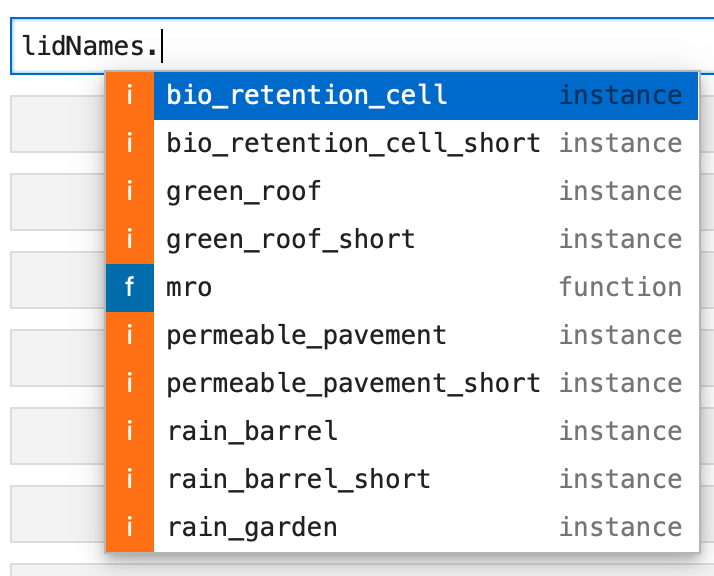
</div>

In [ ]:
lid_param_setup[lidNames.green_roof][lidLayers.surface_layer][lidParams.vegetative_volume] = 0.3
pprint.pprint(lid_param_setup)

Finally, this new setup of the LID controls needs to be written to a new inp file. When writing to a new inp file, the base inp file to use can be specified. This way, any configuration of the scenario beside the parameters of the LID controls that might be important, e.g. the mapping of LID controls to subcatchments, will be kept/copied and only the updated parameters of the LID controls will be written to the file.

In [ ]:
lm.write_lid_control_to_inp(lid_param_setup, new_directory_path_lidparams, new_filename_lidparams, 'baseline', 'Bellinge_2015_mod.inp')

## 2. Setup of a new model with the application of LID controls to subcatchments

As previouisly, first, you need to set the new folder and file names, under which you want to save the modified model. If you do not change this, your previuosly modified model will be overwritten.

In [ ]:
# Adapt these two parameters to save model adaptations to new directories and under meaningful names
new_directory_name_lidapplication = 'test2'
new_filename_lidapplication = 'test2'

new_directory_path_lidapplication = os.path.join(DATA_DIR, new_directory_name_lidapplication)

Next, you can set up a set of lid controls you want to introduce to the model and subsequently, write the modified model to the previously specified folder.

The function `produce_lid_setup_df` has several parameters, explained in the following:
- `lid_type`: The type of LID you want to apply. Types that can be used are specified in `src.utils.lid_names`
- `area_ratio`: The ratio of each of the subcatchments being covered by the LID control. (0 < area_ratio < 1)
- `num_subcatchments`: The number of subcatchments to apply the LID control to. This subcatchments will be taken from the top of the list of subcatchments in the model, which is sorted according to `sort`. Default value is 'all', i.e. all subcatchments in the model.
- `sort`: The way to sort the list of subcatchments by area. 'a' - ascending, 'd' - descending, 'r' - random
- `lid_usages`: The previously specified LID controls to append this new configuration to.
- `subcatchment_list`: A list of subcatchments to apply the specified LID controls to. Arguments `num_subcatchments` and `sort` will be ignored in this case.
<br>

- The LID controls as specified as a DataFrame to be written to a .inp file via `src.utils.auxiliary_functions.write_lid_setup_to_inp`
<br>

- The two lists in the following cell (`connected_subcatchments` & `upstream_subcatchments`) can be used to modify the subcatchments directly connected to the flooded node or connected to the upstream sewer network of the node, respectively.

In [ ]:
connected_subcatchments = pd.Series(['G72F710_8051', 'G72F700_8050'])
upstream_subcatchments = pd.Series(['G72F720_8052', 'G72F730_8053', 'G72F740_8054', 'G72F760_8055', 
                                    'G72F766_8056', 'G72F767_8057', 'G72F768_8058', 'G72F770_8059',
                                    'G72F771_8060', 'G72F773_8061', 'G72F774_8062'])

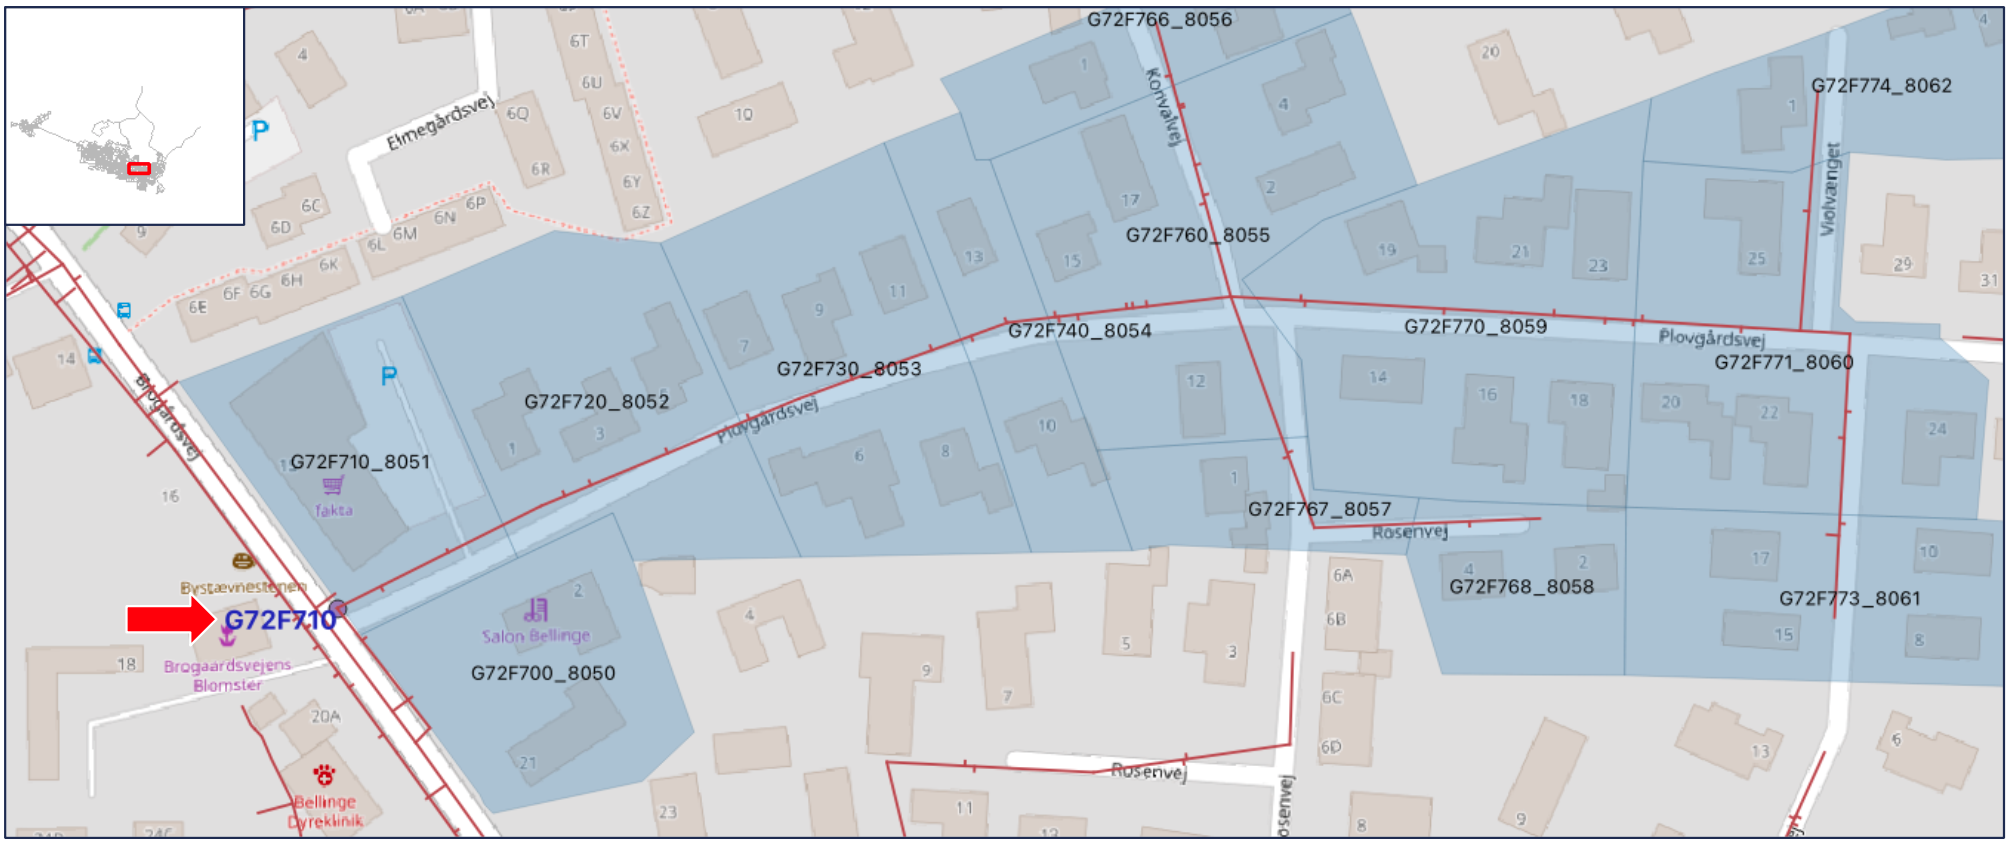

In [ ]:
# Here you can adapt the constellation of the LID controls you want to introduce

lid_setup = aux.produce_lid_setup_df(lid_type=lidNames.green_roof,
                                    area_ratio=1.0,
                                    num_subcatchments=100,
                                    sort='d')

lid_setup = aux.produce_lid_setup_df(lid_type=lidNames.bio_retention_cell,
                                    area_ratio=0.3,
                                    subcatchment_list=upstream_subcatchments,
                                    lid_usages=lid_setup)

lid_setup = aux.produce_lid_setup_df(lid_type=lidNames.rain_barrel,
                                    area_ratio=0.3,
                                    subcatchment_list=upstream_subcatchments,
                                    lid_usages=lid_setup)

lid_setup = aux.produce_lid_setup_df(lid_type=lidNames.rain_garden,
                                    area_ratio=0.3,
                                    subcatchment_list=upstream_subcatchments,
                                    lid_usages=lid_setup)

lid_setup

Finally, this new application of LID controls to subcatchments needs to be written to a new inp file. As a base inp file, we specify the previously built inp file containing the adapted LID control parameters. This new inp file there fore contains all modification we established in this script so far.

In [ ]:
# This just writes the new model to the specified new folder
aux.write_lid_setup_to_inp(lid_usages=lid_setup, 
                           new_dir=new_directory_path_lidapplication, 
                           new_filename=new_filename_lidapplication, 
                           base_inp_dir=new_directory_path_lidparams, 
                           base_inp_filename=new_filename_lidparams)

## 3. Executing the simulation on the new model


In [ ]:
swmm_path = r'/swmm51015_engine/build/runswmm5'
inp_path = os.path.join(new_directory_path_lidapplication, new_filename_lidapplication) + '.inp'

!python3 utils/run_model.py --inp_path '{inp_path}' --swmm_path '{swmm_path}'

## 4. Analysis of the modifications

First, the baseline and the new model are loaded with the swmmio package for further evaluation.

In [ ]:
# Loading the baseline with no LID controls
baseline_model_path = os.path.join(DATA_DIR, 'baseline')
baseline_model = swmmio.Model(baseline_model_path)

# Loading the modified model
mod_model = swmmio.Model(new_directory_path_lidapplication)

Next, the data from node G72F710 is extracted and plotted to evaluate the amount of flooding.

In [ ]:
node_id = 'G72F710'

fig = aux.plot_node_flooding_comparison(node_id=node_id,
                                        model_1_path=baseline_model_path,
                                        model_2_path=new_directory_path_lidapplication,
                                        name_1='Baseline',
                                        name_2='Exemplary LID Setup')

fig.show()

# Uncomment this line and change the filename to save the plot as a html file
fig.write_html(os.path.join(OUTPUT_DIR, 'exemplary_setup_test.html'))

Finally, the absolute mount of flooding is computed to provide a sensible metric to compare model setups.

In [ ]:
node_data_baseline = aux.get_node_df(node_id, baseline_model_path)
abs_flooding_baseline = (node_data_baseline['FloodingCFS']*5*60).sum()

node_data_mod = aux.get_node_df(node_id, new_directory_path_lidapplication)
abs_flooding_mod = (node_data_mod['FloodingCFS']*5*60).sum()

print('Flooding in baseline scenario:\t' + str(round(abs_flooding_baseline, 2)) 
      + ' m^3\nFlooding in adapted scenario:\t' 
      + str(round(abs_flooding_mod, 2)) + ' m^3\nAccounting for a reduction of:\t  ' 
      + str(round(100-(100*abs_flooding_mod/abs_flooding_baseline), 1)) + ' %')

## 5. Setup of a sensitivity analysis with SALib

First, the additionally necessary imports.

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol

import numpy as np
import plotly.graph_objects as go

### Function to be investigated

Next, you need to define a function which the sensitivit analysis can be performed on. This function needs to take all necessary arguments as a list or array, which can be unpacked inside the function as shown. Finally, the function needs to provide one scalar output.

In [ ]:
def some_function(parameters):
    x, y, z = parameters
    output = x + 2 * y + 5 * z
    return output

### Problem definition

Define the problem, i.e. define the input parameters and their ranges to be investigated. This needs to be aligned with the setup of your function from above.

In [ ]:
problem = {
    'num_vars': 3,
    'names': ['x', 'y', 'z'],
    'bounds': [[-2, 3],
               [-1, 1],
               [-6, 2]]}

### Generating samples

Generate the samples of parameter combinations according the specified ranges. For this, the Saltelli sampling method is used, which generates samples, i.e. combinations of paramters values, distributed in the parameter space and within the previously specified parameter ranges. The number is specified as the second argument of the function. The sampling scheme of Saltelli is an extension to and optimization of the original sobol sequence sampling scheme, which is a 'popular quasi-random low-discrepancy sequence used to generate uniform samples of parameter space'. For mathematical details, see http://www.andreasaltelli.eu/file/repository/Screening_CPC_2011.pdf

In [ ]:
param_samples = saltelli.sample(problem, 32)
print('Generated {} parameter combinations.'.format(param_samples.shape[0]))
param_samples[:10, :]

### Model execution

SALib is not executing the model/function itself. For this, you need to iterate over the input parameter samples themselves to produce the output values.

In [ ]:
resulting_outputs = np.zeros(shape=(param_samples.shape[0]))

for i, param_sample in enumerate(param_samples):
    resulting_outputs[i] = some_function(param_sample)

### Performing the analysis

Now you have everything to do the actual sensitivity analysis. The algorithm chosen here is the calculation of sobol indices. We provide the algorithm with the combination of input parameters together with the resulting output of the model/function. Then the algorithm calculates the first, second and total order indices. The _first oder_ indices (`'S1'`) signify how much the variability of each input parameter influences the veriation in the output. The _second order_ indices (`'S2'`) analyze the combination of two parameters each, i.e. how the combined variation of two input paramters influences the output. Finally, the _total order_ indices (`'ST'`) are a combination of the latter two. Additionally, the function also provides the confindece intervals.

In [ ]:
Si = sobol.analyze(problem, resulting_outputs, print_to_console=True)

### Plotting the results

Plotting the first order indices.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['x', 'y', 'z'], y=Si['S1'], error_y=dict(type='data', array=Si['S1_conf'])))
fig.update_layout(title='First order sensitivity indices', font=dict(size=15))
fig.show()

Plotting the second order indices.

In [ ]:
# Condition matrix to be symmetric
S2_mat = Si['S2']
S2_mat[np.isnan(S2_mat)] = 0
S2_mat = np.rot90(S2_mat.T + S2_mat)

S2_conf = Si['S2_conf']
S2_conf[np.isnan(S2_conf)] = 0
S2_conf = np.rot90(S2_conf.T + S2_conf)

fig = go.Figure()
fig.add_trace(go.Heatmap(z=S2_mat, x=['x', 'y', 'z'], y=['z', 'y', 'x'], customdata=S2_conf, 
                        hovertemplate='Combination %{y} - %{x}: %{z:.3f} ± %{customdata}'))
fig.update_layout(title='Second order sensitivity indices', font=dict(size=15))

fig.show()

Plotting the total order indices.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['x', 'y', 'z'], y=Si['ST'], error_y=dict(type='data', array=Si['ST_conf'])))
fig.update_layout(title='Total order sensitivity indices', font=dict(size=15))
fig.show()